In [181]:
import anndata
import cellxgene_census
import numpy as np
from mizani.transforms import trans, trans_new
from mizani import breaks, formatters
import pandas as pd
import plotnine as p
from scipy import stats
import scvi
from scvi.hub import HubMetadata, HubModel, HubModelCardHelper

class neg_log10(trans):
    @staticmethod
    def transform(x):
        return -np.log10(x)

    @staticmethod
    def inverse(x):
        return 10 ** -x


class trans_log10(trans):
    @staticmethod
    def transform(x):
        return np.log10(x)

    @staticmethod
    def inverse(x):
        return 10 ** x


class neg_log10_breaks:
    def __init__(self, n = 5):
        self.n = n

    def __call__(self, limits):
        _min = int(np.floor(np.log10(limits[1])))
        breaks = np.array([[10. ** k, 5. * 10. ** (k - 1)] for k in range(0, _min, -1)]).ravel()

        return breaks.tolist()

In [2]:
hmo = HubModel.pull_from_huggingface_hub(
    repo_name = 'valsv/240308.mouse_census.baseline.model',
)

/tmp/ipykernel_395849/3992181586.py:1: UserWarning: No revision was passed, so the default (latest) revision will be used.


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

_scvi_required_metadata.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

adata.h5ad:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/171M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.00k [00:00<?, ?B/s]

In [3]:
model = hmo.model
model

INFO     Loading model...                                                                                          
INFO     File                                                                                                      
         /home/vale/.cache/huggingface/hub/models--valsv--240308.mouse_census.baseline.model/snapshots/e1b86c8f503a
         529779846f273c15d2ac02ee225a/model.pt already downloaded                                                  


/home/vale/mambaforge/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
/home/vale/mambaforge/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


SCVI Model with the following params: 
n_hidden: 128, n_latent: 32, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [4]:
census = cellxgene_census.open_soma()

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


In [5]:
adata = cellxgene_census.get_anndata(
    census = census,
    organism = 'Mus musculus',
    obs_value_filter = "tissue == 'spleen' and is_primary_data == True"
)

In [6]:
adata

AnnData object with n_obs × n_vars = 39552 × 52417
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [9]:
model.adata = adata
model.adata.var = model.adata.var.set_index('feature_name')

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 4 in image.
/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig21.png


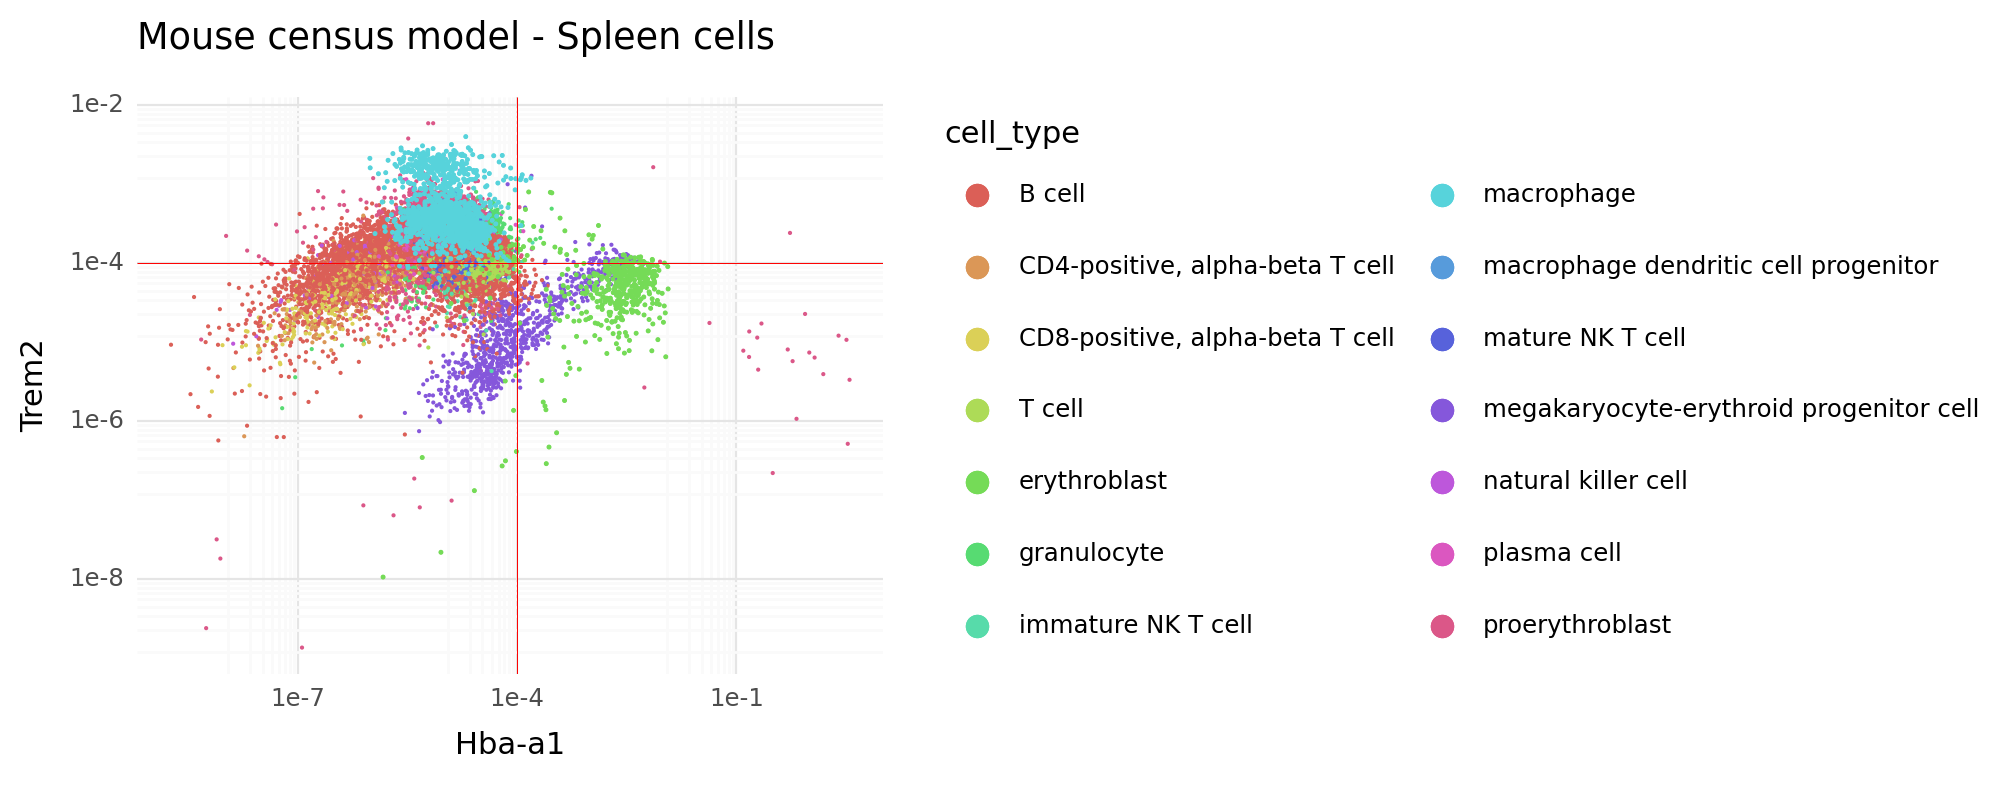

In [187]:
g1_, g2_ = 'Hba-a1', 'Trem2'

tmp_ = model.adata[model.adata.obs.index].copy()

gexp_ =  model.get_normalized_expression(adata = tmp_, gene_list = [g1_, g2_])
tmp_.obs['g1_'] = gexp_[g1_]
tmp_.obs['g2_'] = gexp_[g2_]


p.options.figure_size = 10, 4

p_ = (
    p.ggplot(p.aes(x = 'g1_', y = 'g2_', color = 'cell_type'), tmp_.obs)
    + p.geom_point(shape = '.', size = 0.2)
    + p.geom_point(shape = '.', size = 0.5, data = tmp_.obs.query('cell_type in ["erythroblast", "macrophage"]'))
    + p.geom_hline(yintercept = 1e-4, color = 'red', size = 0.2)
    + p.geom_vline(xintercept = 1e-4, color = 'red', size = 0.2)
    + p.scale_x_log10()
    + p.scale_y_log10()
    + p.theme_minimal()
    + p.guides(color = p.guide_legend(override_aes = {'size': 8}, ncol = 2))
    + p.labs(x = g1_, y = g2_, title = 'Mouse census model - Spleen cells')
)

p_.save('fig21.png', dpi = 300)

print(p_)

In [12]:
de_results = model.differential_expression(groupby = 'cell_type')

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [06:27<00:00, 27.69s/it]


In [13]:
de_results['gene'] = de_results.index

In [173]:
top_markers = []
for n_, grp_ in de_results.groupby(['comparison']):
    top_ = (
        grp_
        .query('proba_de > 0.9')
        .query('lfc_median > 0')
        .sort_values('lfc_median', ascending = False)
        .head(5)
    )
    top_markers += [top_]

top_markers = pd.concat(top_markers)

marker_genes = (
    top_markers
    .sort_values('lfc_median', ascending = False)
    .groupby(['gene'])
    .first()
    .reset_index()
    .sort_values(['comparison', 'lfc_median'], ascending = [True, False])
    .copy()
)

marker_genes = (
    marker_genes
    .reset_index(drop = True)
    .reset_index()
    .rename(columns = {'index': 'gene_index'})
    .copy()
)

top_markers = top_markers.merge(marker_genes, how = 'outer')

markers_ = marker_genes['gene'].values

marker_de = de_results.query('gene in @markers_').copy()

g2i = marker_genes.set_index('gene')['gene_index']
marker_de['gene_index'] = marker_de['gene'].map(g2i)

g2g1 = marker_genes.set_index('gene')['group1']
marker_de['marker_name'] = marker_de['gene'].map(g2g1) + ' - ' + marker_de['gene']

/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 11 x 6 in image.
/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig22.png


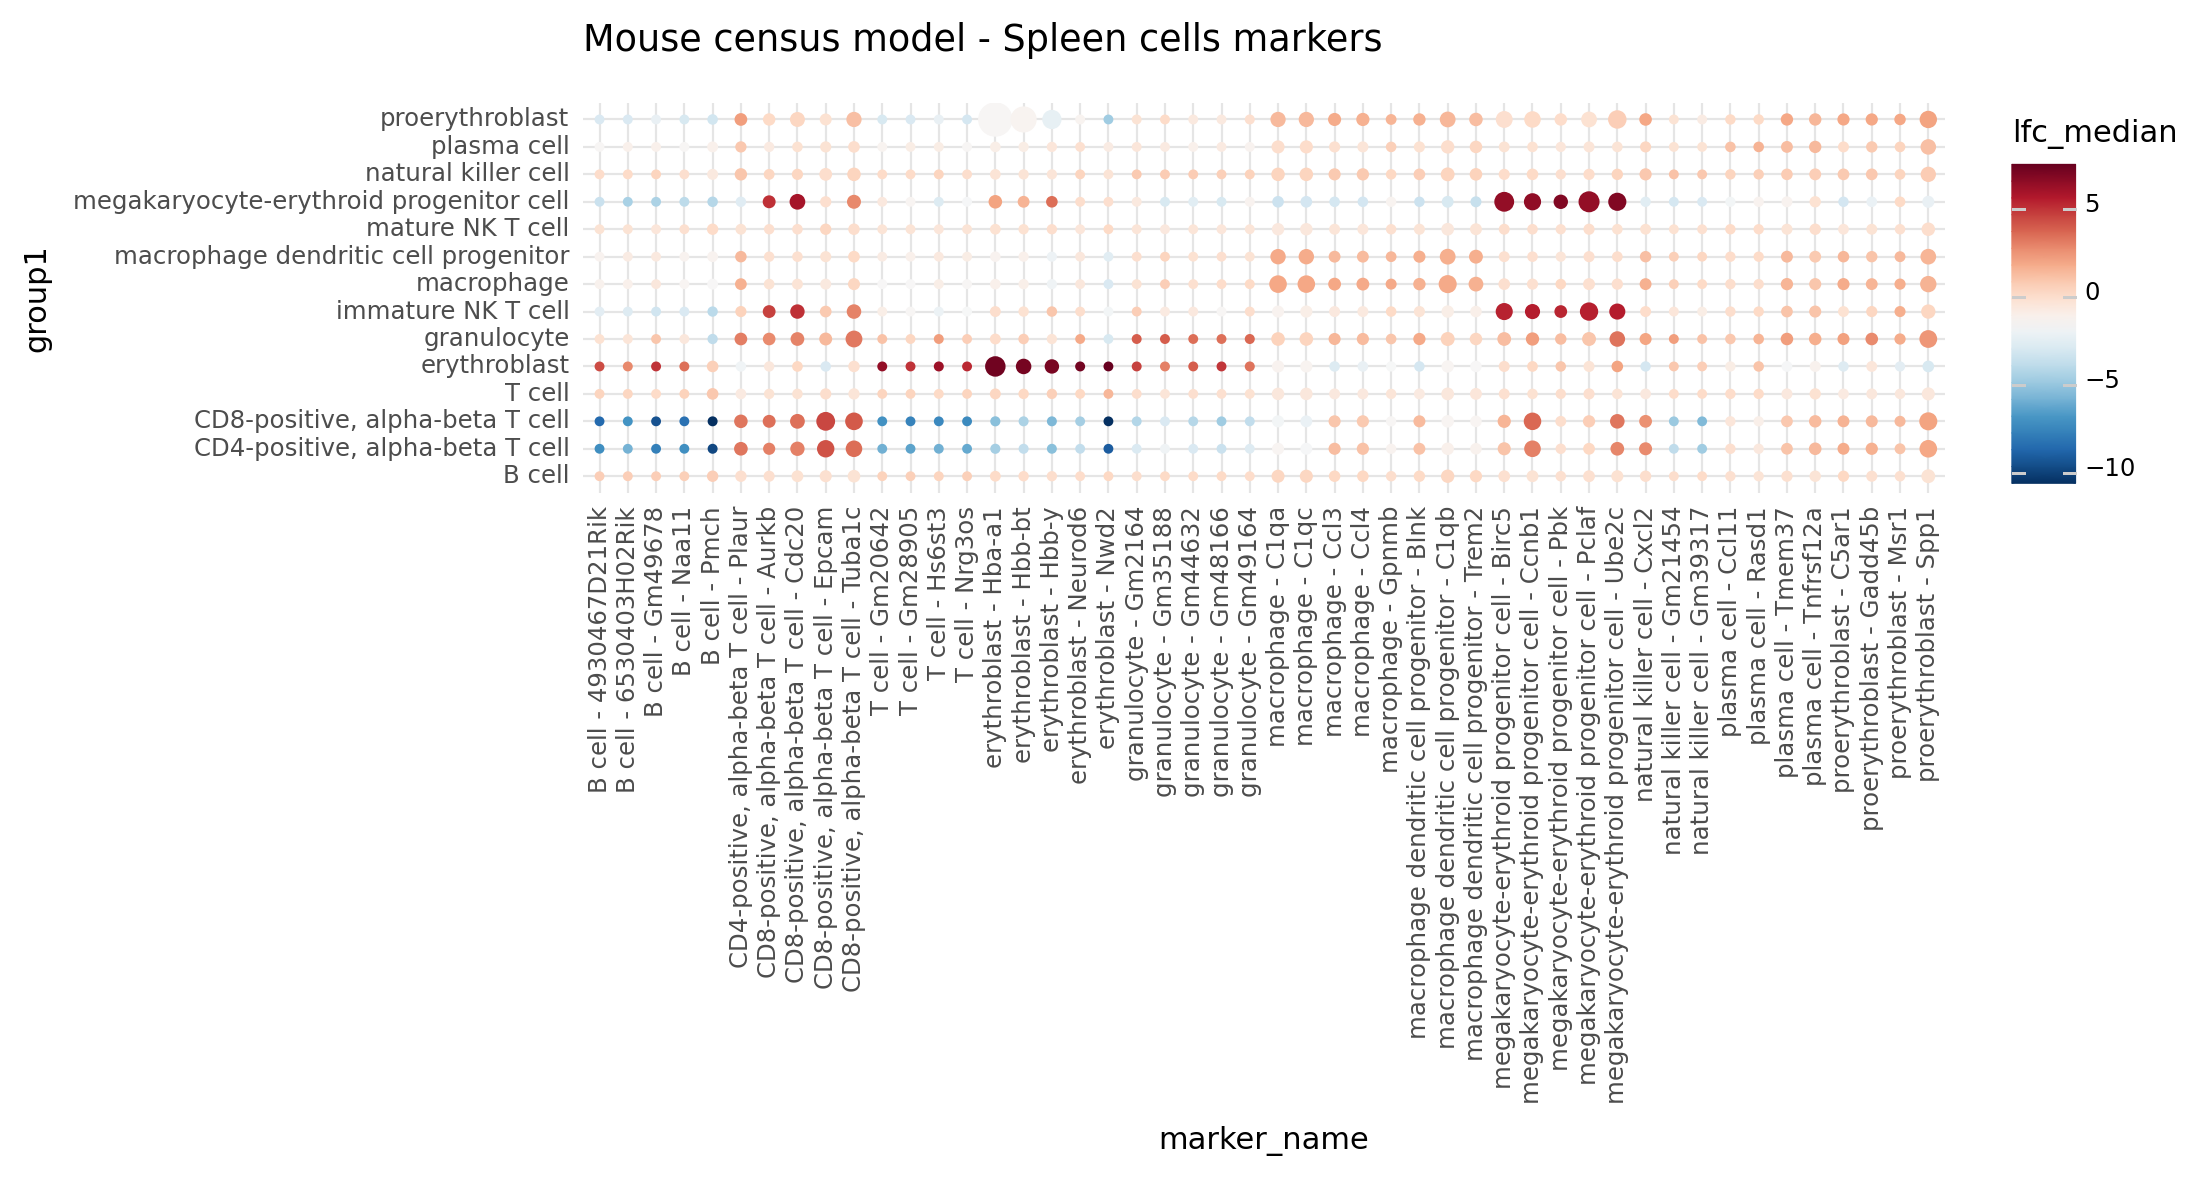

In [179]:
p.options.figure_size = 11, 6

p_ = (
    p.ggplot(p.aes(x = 'marker_name', y = 'group1', color = 'lfc_median', size = 'scale1'), marker_de)
    + p.geom_point()
    + p.scale_color_continuous(cmap_name = 'RdBu_r')
    + p.theme_minimal()
    + p.theme(axis_text_x = p.element_text(angle=90, hjust = 0.5))
    + p.guides(size = False)
    + p.labs(title = 'Mouse census model - Spleen cells markers')
)

p_.save('fig22.png', dpi = 300)

print(p_)

In [182]:
model.adata.obsm['X_scvi'] = model.get_latent_representation()

model.adata.obsm['X_mde'] = scvi.model.utils.mde(model.adata.obsm['X_scvi'])

for i, y in enumerate(model.adata.obsm['X_mde'].T):
    model.adata.obs[f'mde_{i + 1}'] = y

/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 10 in image.
/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig23.png


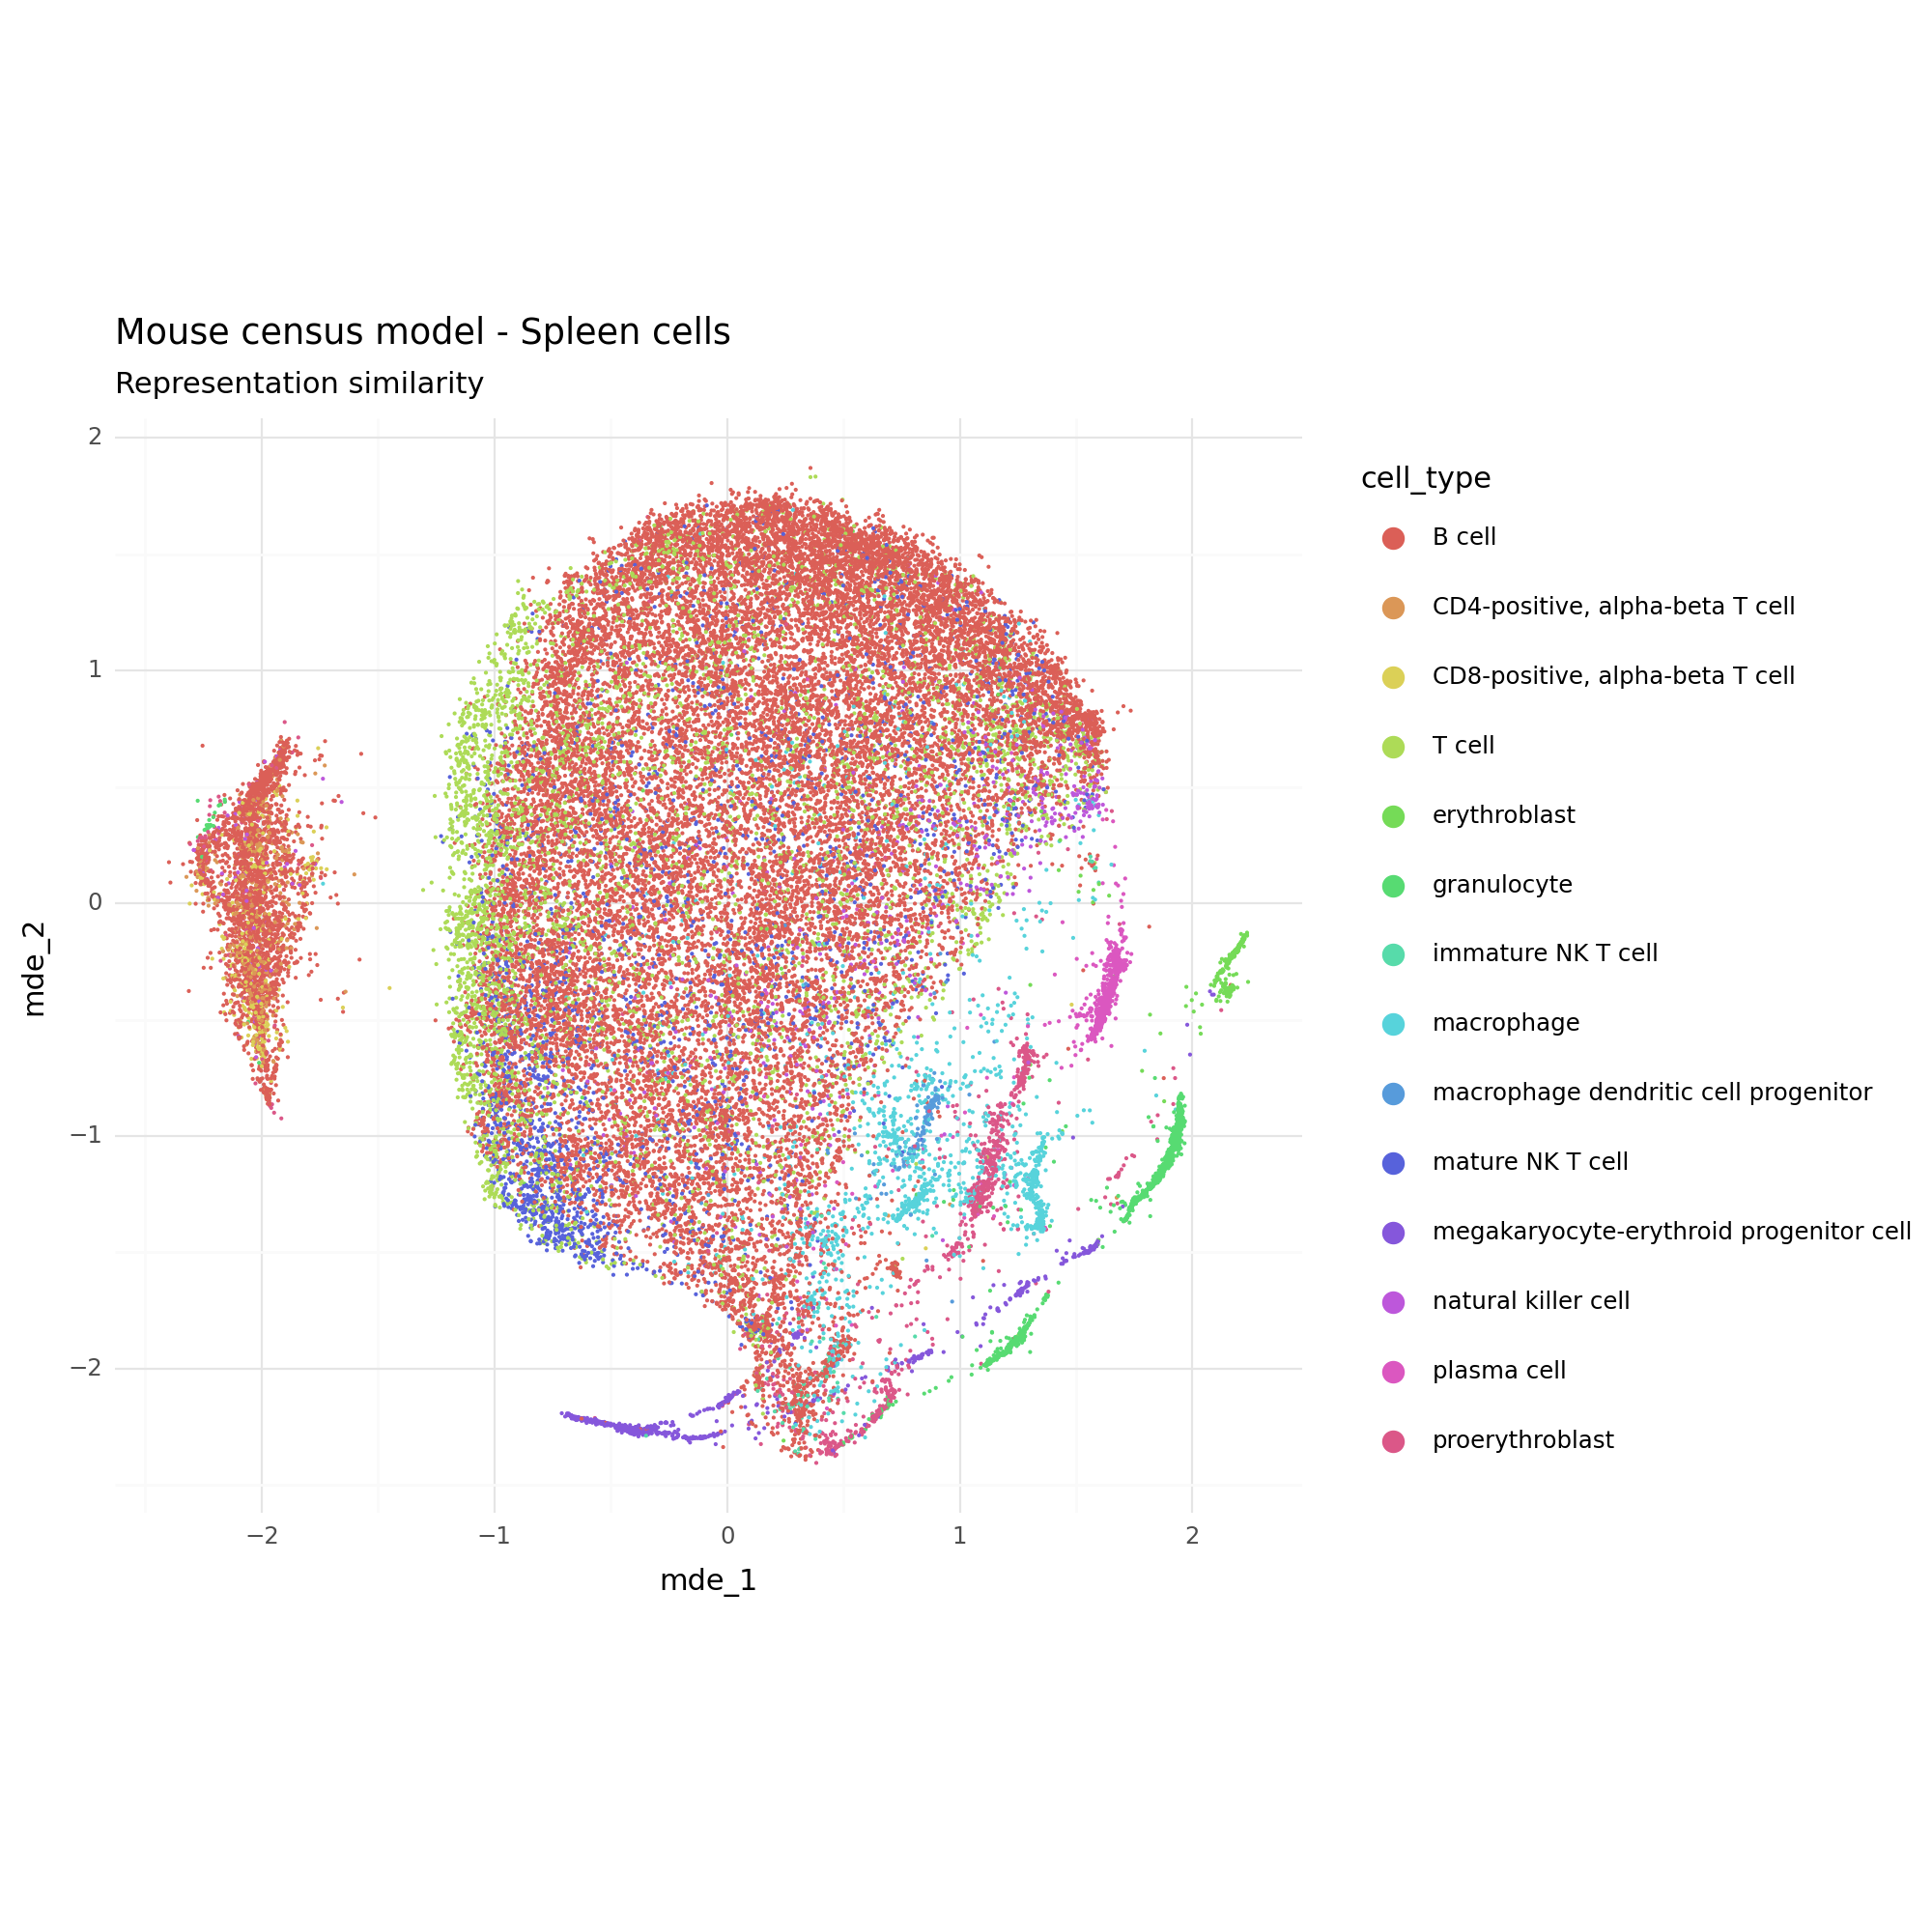

In [188]:
p.options.figure_size = 10, 10

tmp_ = model.adata.obs.copy()

p_ = (
    p.ggplot(p.aes(x = 'mde_1', y = 'mde_2', color = 'cell_type'), tmp_)
    + p.geom_point(shape = '.', size = 0.2)
    + p.coord_equal()
    + p.theme_minimal()
    + p.guides(color = p.guide_legend(override_aes = {'size': 8}))
    + p.labs(title = 'Mouse census model - Spleen cells', subtitle = 'Representation similarity')
)

p_.save('fig23.png', dpi = 300)

print(p_)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 4 in image.
/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig31.png


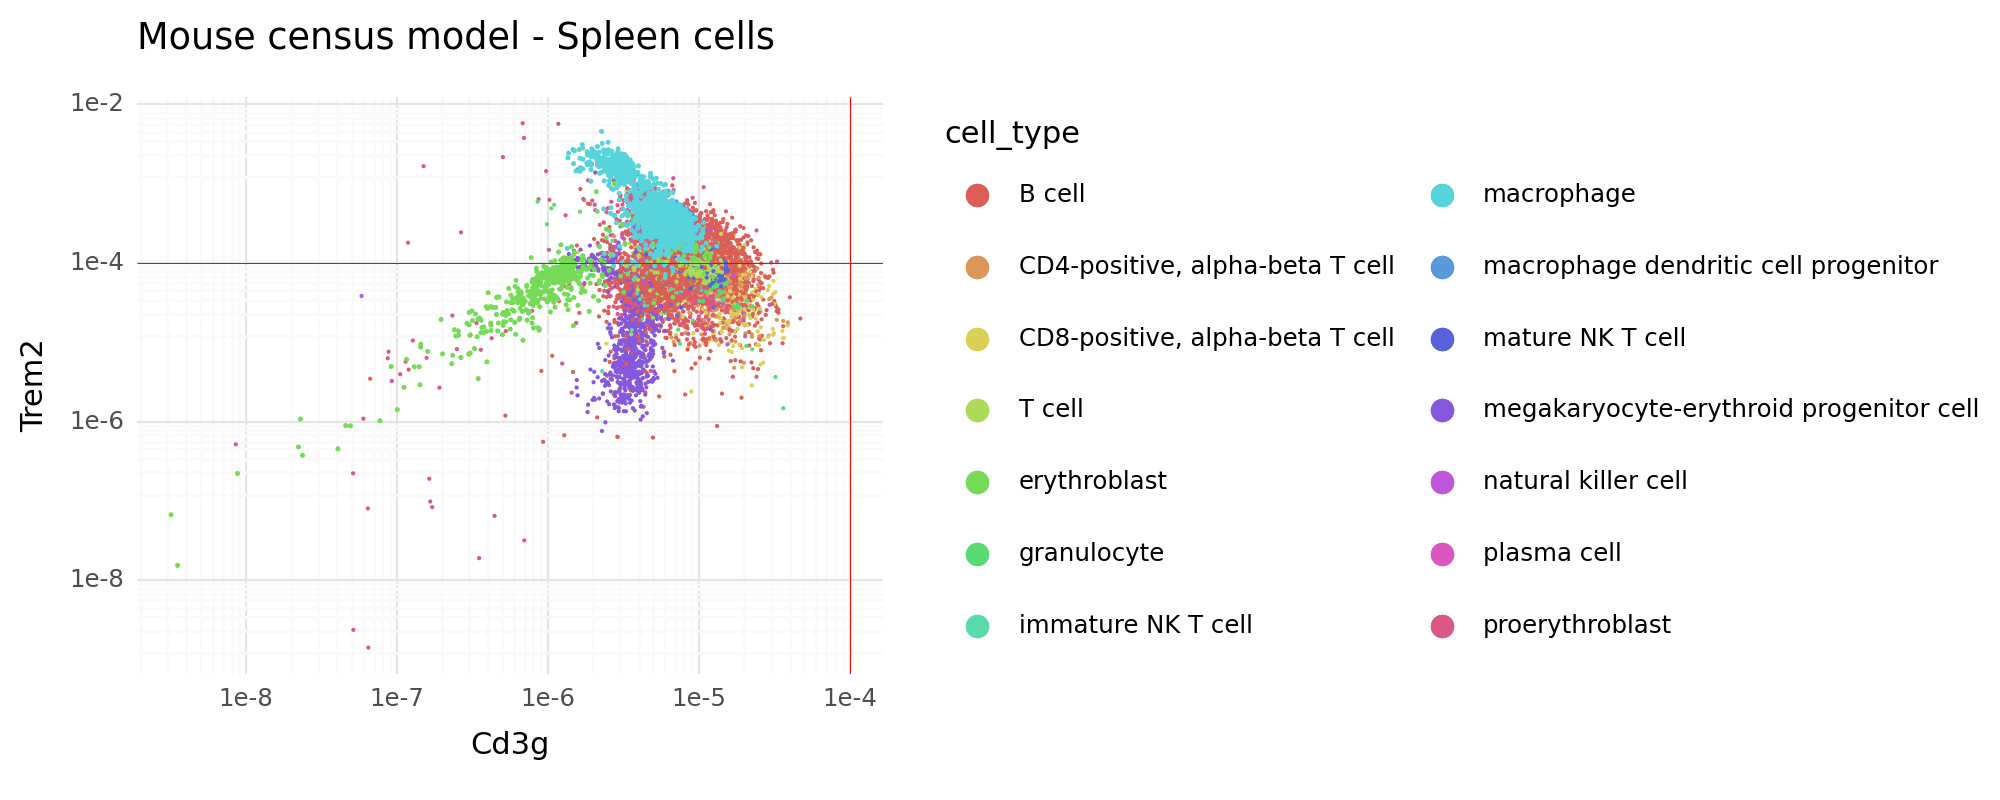

In [189]:
g1_, g2_ = 'Cd3g', 'Trem2'

tmp_ = model.adata[model.adata.obs.index].copy()

gexp_ =  model.get_normalized_expression(adata = tmp_, gene_list = [g1_, g2_])
tmp_.obs['g1_'] = gexp_[g1_]
tmp_.obs['g2_'] = gexp_[g2_]


p.options.figure_size = 10, 4

p_ = (
    p.ggplot(p.aes(x = 'g1_', y = 'g2_', color = 'cell_type'), tmp_.obs)
    + p.geom_point(shape = '.', size = 0.2)
    + p.geom_point(shape = '.', size = 0.5, data = tmp_.obs.query('cell_type in ["erythroblast", "macrophage"]'))
    + p.geom_hline(yintercept = 1e-4, color = 'red', size = 0.2)
    + p.geom_vline(xintercept = 1e-4, color = 'red', size = 0.2)
    + p.scale_x_log10()
    + p.scale_y_log10()
    + p.theme_minimal()
    + p.guides(color = p.guide_legend(override_aes = {'size': 8}, ncol = 2))
    + p.labs(x = g1_, y = g2_, title = 'Mouse census model - Spleen cells')
)

p_.save('fig31.png', dpi = 300)

print(p_)

/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 10 in image.
/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig32.png


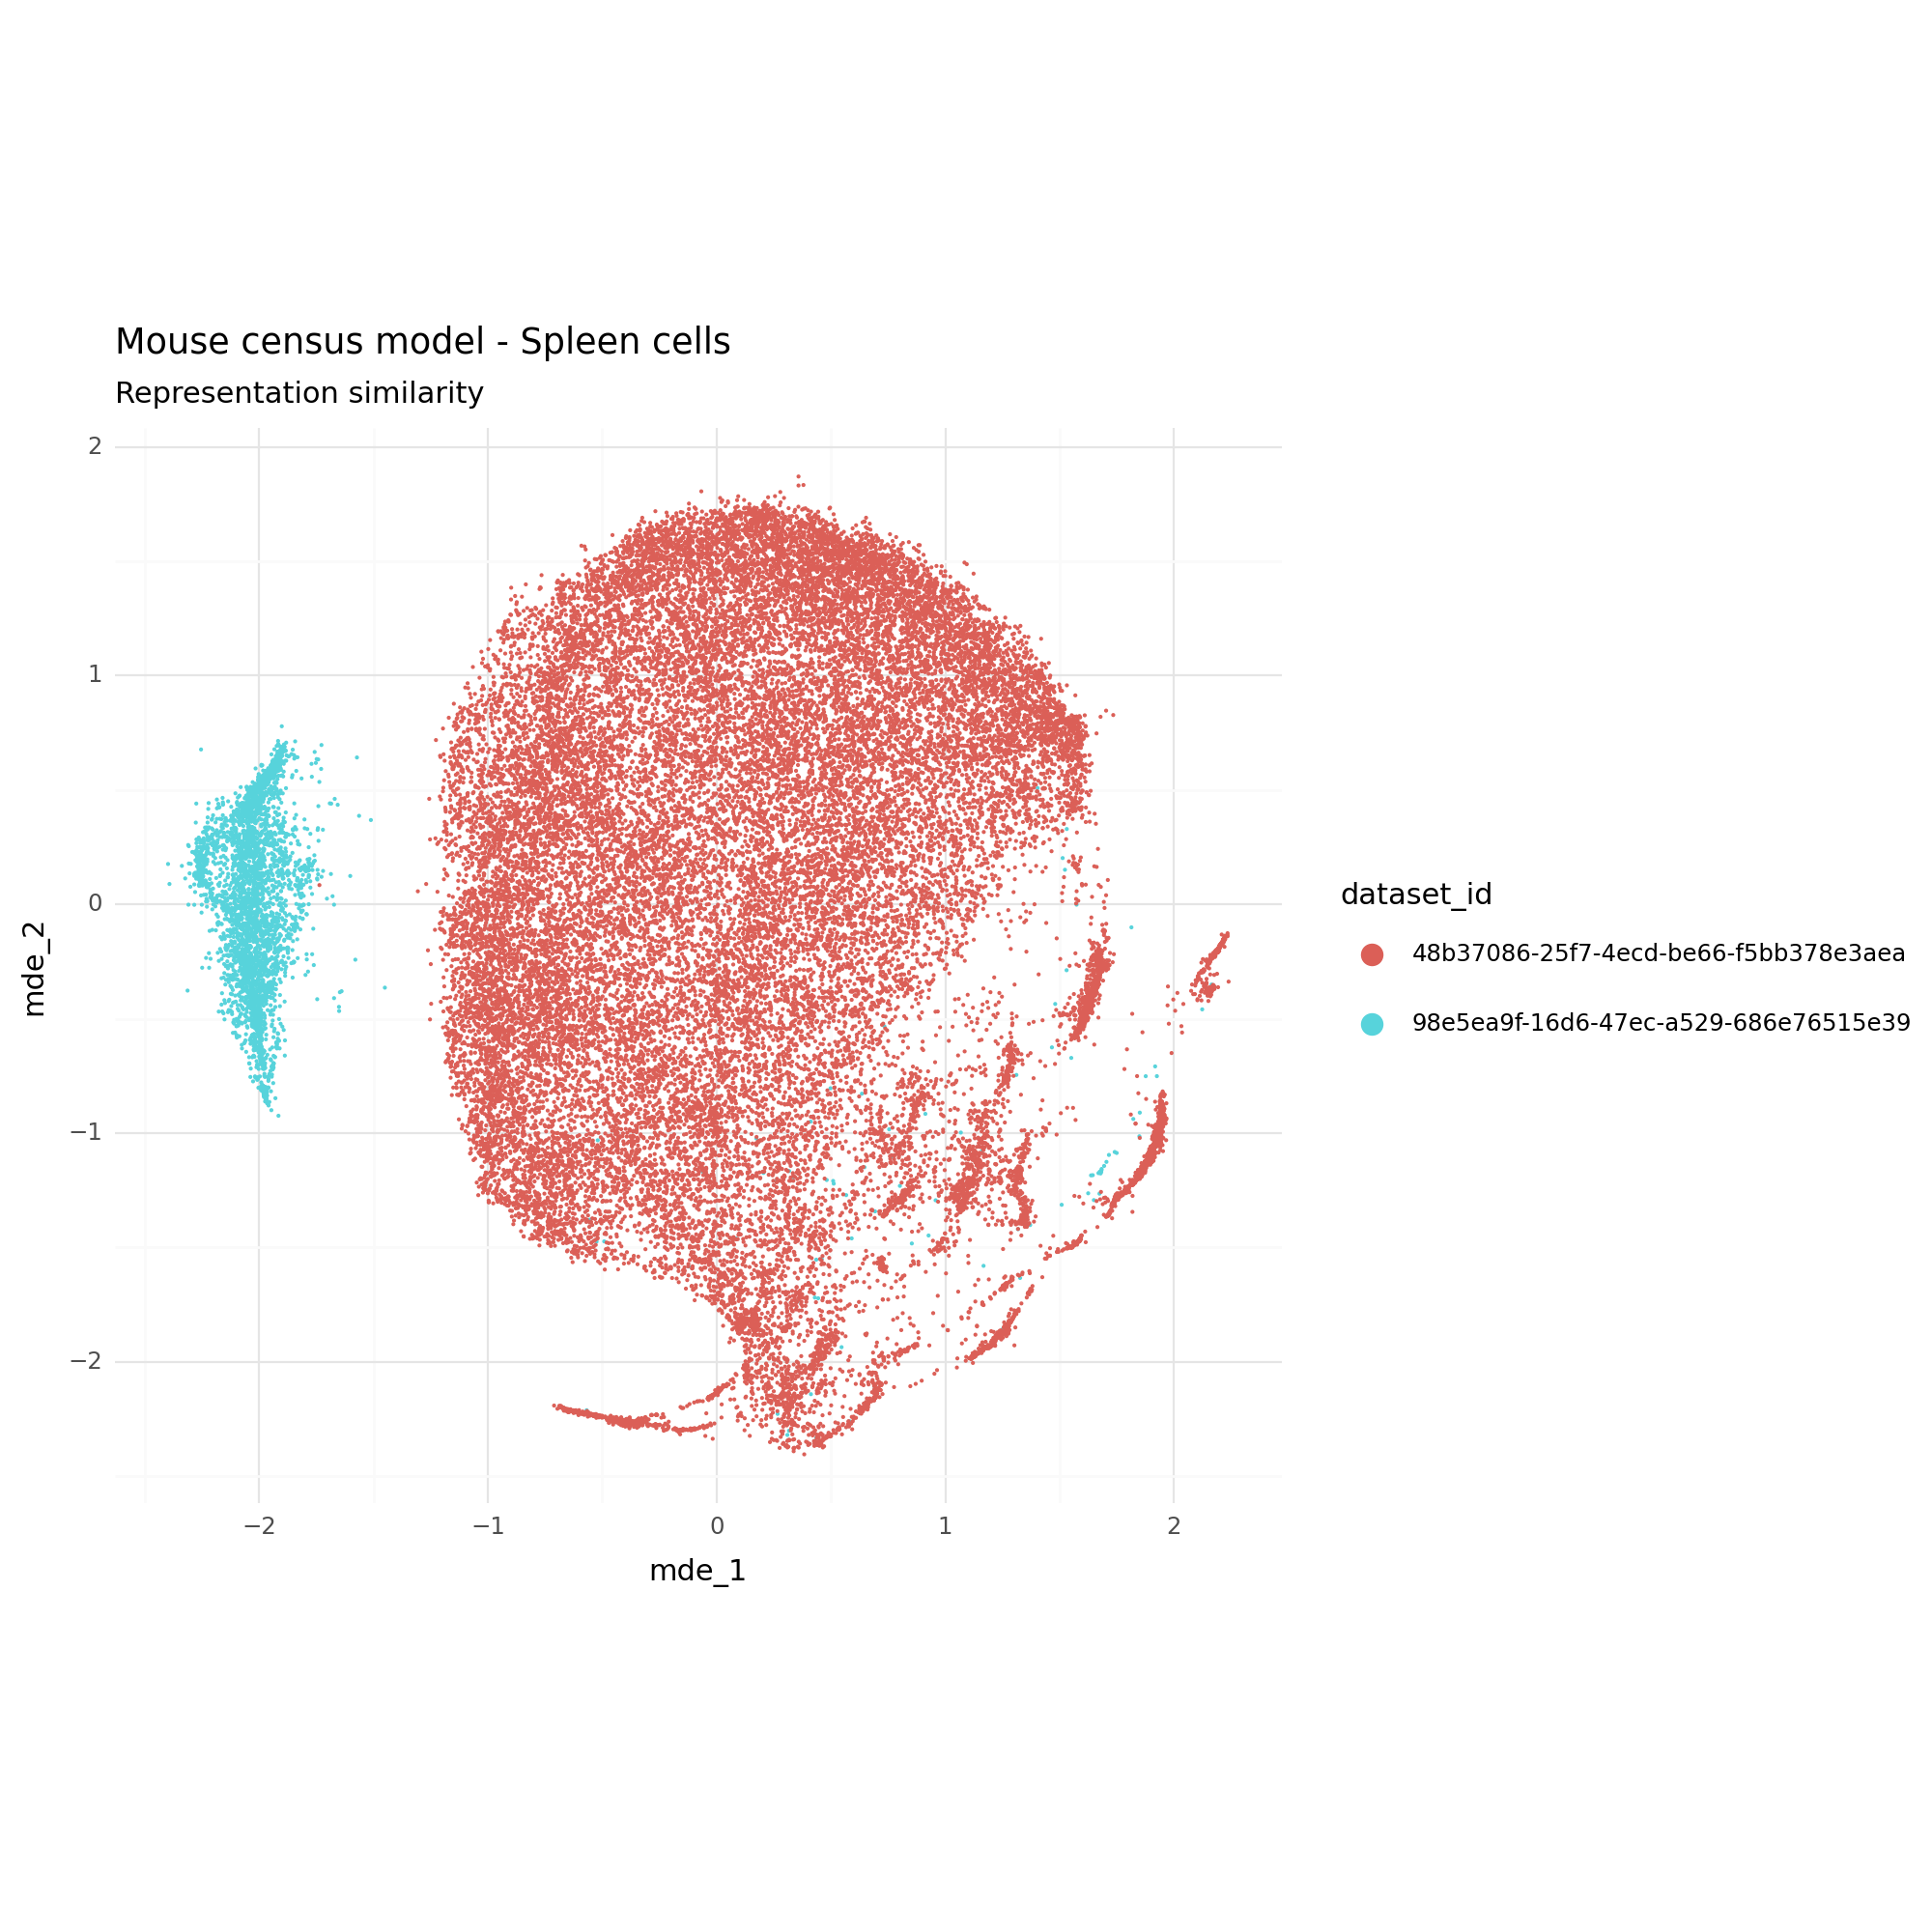

In [190]:
p.options.figure_size = 10, 10

tmp_ = model.adata.obs.copy()

p_ = (
    p.ggplot(p.aes(x = 'mde_1', y = 'mde_2', color = 'dataset_id'), tmp_)
    + p.geom_point(shape = '.', size = 0.2)
    + p.coord_equal()
    + p.theme_minimal()
    + p.guides(color = p.guide_legend(override_aes = {'size': 8}))
    + p.labs(title = 'Mouse census model - Spleen cells', subtitle = 'Representation similarity')
)

p_.save('fig32.png', dpi = 300)

print(p_)